In [28]:
import numpy as np

X = np.load('../mount/Data_Manipulation_datasets/processed_X.npy')
Y = np.load('../mount/Data_Manipulation_datasets/processed_Y.npy')

## Logistic Regression

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = LogisticRegression()

model.fit(X_train, Y_train)

print("Train accuracy: ", model.score(X_train, Y_train))
print("Test accuracy: ", model.score(X_test, Y_test))

AUC = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])

print(" AUC: ", AUC)

Train accuracy:  0.9131375227686703
Test accuracy:  0.913023679417122
 AUC:  0.9422956534437759


Model seems to fit well with both high train and validation accuracy. The target metric here (Area under the Reciever Operating Characteristics) is also pretty high.

In [40]:
# cross validation 
from sklearn.model_selection import cross_val_score

model = LogisticRegression()

scores = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')

print("Mean AUC: ", scores.mean())
print("Std AUC: ", scores.std())

Mean AUC:  0.9382509328333029
Std AUC:  0.004046840468976419


The cross-validation also gives a similar high mean AUC with very small spread (standard deviation)

These high accuracy predictions might be because of high representation of negative cases 

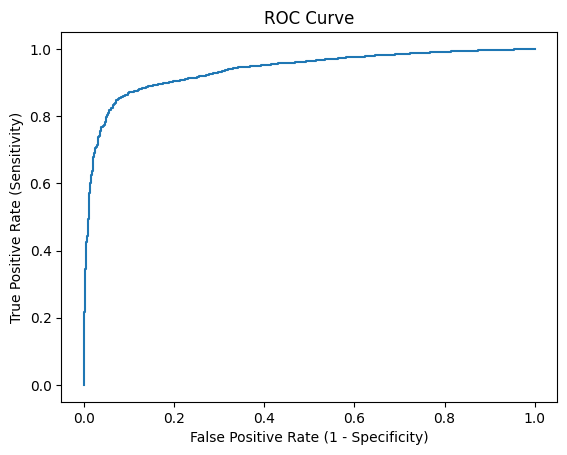

In [77]:
# RoC curve 
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

Y_scores = cross_val_predict(model, X, Y, cv=10, method='decision_function')
fpr, tpr, thresholds = roc_curve(Y, Y_scores)

#model = LogisticRegression()
#model.fit(X_train, Y_train)
Y_scores = model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_scores)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.show()

In [42]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

#Y_pred = cross_val_predict(model, X, Y, cv=10)
#tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()

Y_pred = model.predict(X_test)
tp, fn, fp, tn = confusion_matrix(Y_test, Y_pred).ravel()

print("True positives: ", tp)
print("False negatives: ", fn)
print("False positives: ", fp)
print("True negatives: ", tn)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Precision: ", precision)
print("Recall: ", recall)

True positives:  314
False negatives:  407
False positives:  170
True negatives:  5697
Precision:  0.6487603305785123
Recall:  0.435506241331484


In [44]:
confusion_matrix(Y_test, Y_pred)

array([[ 314,  407],
       [ 170, 5697]], dtype=int64)

As can be seen very clearly, although the model has high accuracy and AuC (because of the large number of negative samples), both the precision and recall scores are not high enough. Especially, we want a high recall score (higher ability to capture all the instances of positive)

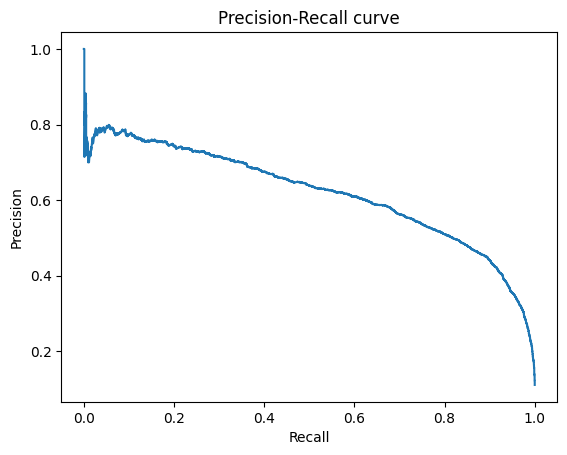

In [75]:
# Precision-Recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

Y_scores = cross_val_predict(model, X, Y, cv=10, method='predict_proba')
precisions, recalls, thresholds = precision_recall_curve(Y, Y_scores[:, 0], pos_label=0)

#Y_scores = model.predict_proba(X_test)[:, 0]
#precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_scores, pos_label=0)

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve') 
plt.show()

Although it was not clear from the AUC and ROC curve (due to small number of positive instances), but the precision-recall curve gives a clearer picture why the classifier is not a good classifier. The precision is drastically decreasing if we aim for a good recall which we are trying to get. So, the target would be to get as higher AUPRC (Area under Precision Recall Curve)

In [78]:
from sklearn.metrics import auc 

AUPRC = auc(recalls, precisions)

print("AUPRC: ", AUPRC)

AUPRC:  0.6192059714226329


# Evaluation metric function

In [96]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import os

def evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=None):
    tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    AUC = roc_auc_score(Y, Y_prob[:, 1])
    
    print("||>> Precision: ", precision)
    print("||>> Recall: ", recall)
    print("||>> F1: ", f1)
    print("||>> Accuracy: ", accuracy)
    print("||>> AUC: ", AUC)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'roc_curve.png'))
    else:
        plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(Y, Y_prob[:, 0], pos_label=0)
    plt.cla()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve') 
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'precision_recall_curve.png'))
    else:
        plt.show()
    
    AUPRC = auc(recalls, precisions)
    print("||>> AUPRC: ", AUPRC)
    
    return precision, recall, f1, accuracy, AUC, AUPRC

||>> Precision:  0.656969696969697
||>> Recall:  0.44329334787350055
||>> F1:  0.5293830376037766
||>> Accuracy:  0.912234365513054
||>> AUC:  0.9382859945882682


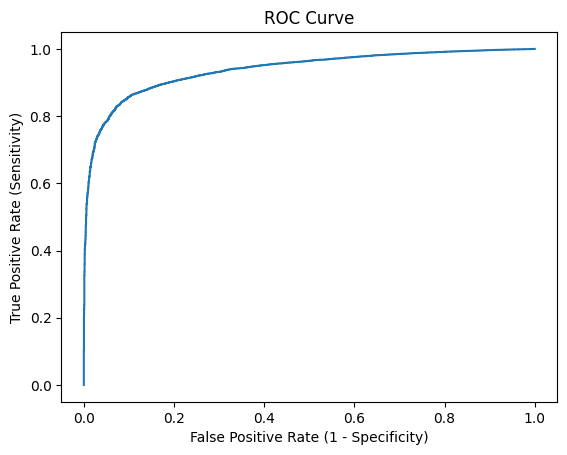

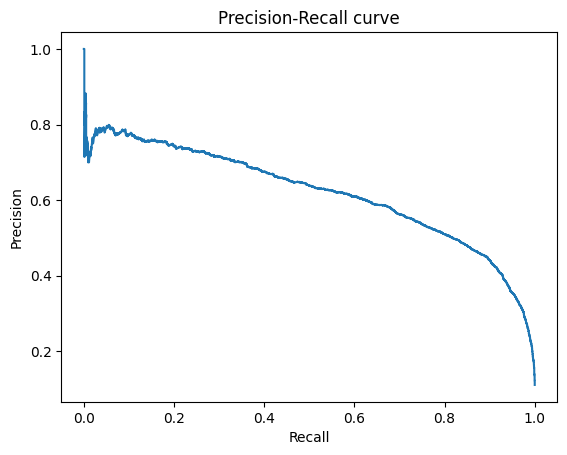

||>> AUPRC:  0.6192059714226329


(0.656969696969697,
 0.44329334787350055,
 0.5293830376037766,
 0.912234365513054,
 0.9382859945882682,
 0.6192059714226329)

In [97]:
from sklearn.model_selection import cross_val_predict

model = LogisticRegression()

Y_pred = cross_val_predict(model, X, Y, cv=10)
Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')

evaluation_metrics(Y, Y_pred, Y_prob)

# Save Model Function

In [98]:
import joblib

def save_model_and_performance(model, X, Y, model_name):
    model_dir = os.path.join('../mount/trained_models', model_name)
    os.makedirs(model_dir)
    joblib.dump(model, os.path.join(model_dir, 'model.pkl'))
    
    Y_pred = cross_val_predict(model, X, Y, cv=10)
    Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')
    
    precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=model_dir)
    with open(os.path.join(model_dir, 'metrics.txt'), 'w') as f:
        f.write("Precision: {}\n".format(precision))
        f.write("Recall: {}\n".format(recall))
        f.write("F1: {}\n".format(f1))
        f.write("Accuracy: {}\n".format(accuracy))
        f.write("AUC: {}\n".format(AUC))
        f.write("AUPRC: {}\n".format(AUPRC))

||>> Precision:  0.656969696969697
||>> Recall:  0.44329334787350055
||>> F1:  0.5293830376037766
||>> Accuracy:  0.912234365513054
||>> AUC:  0.9382859945882682
||>> AUPRC:  0.6192059714226329


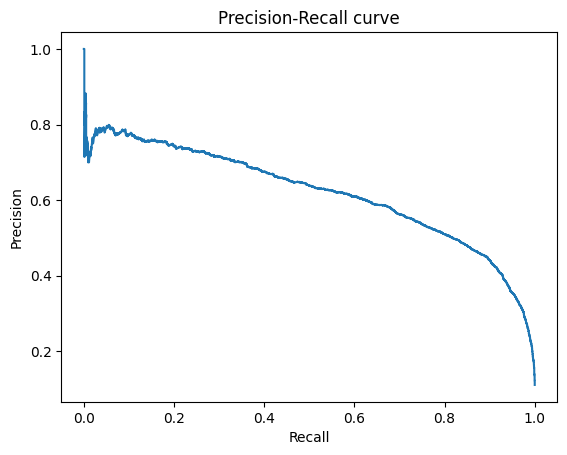

In [105]:
save_model_and_performance(model, X, Y, 'logistic_regression')

In [106]:
model = joblib.load('../mount/trained_models/logistic_regression/model.pkl')

model.predict(X[:10])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

# Decision Trees

In [126]:
from sklearn.tree import DecisionTreeClassifier 

model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test) 

print("Train accuracy: ", train_score)
print("Test accuracy: ", test_score)

Train accuracy:  1.0
Test accuracy:  0.8908621736490588


In [127]:
model.tree_.n_leaves, model.tree_.max_depth

(1922, 32)

In [128]:
model.feature_importances_

array([3.40913346e-01, 3.20780857e-02, 2.13446922e-02, 1.18515512e-02,
       7.93546830e-02, 8.71312460e-03, 8.04076419e-02, 3.94225391e-03,
       1.52983769e-01, 2.25817565e-02, 1.06467231e-02, 5.05521328e-03,
       3.17645735e-03, 2.39470879e-03, 8.65622215e-03, 3.27955046e-03,
       1.93105235e-03, 6.49862090e-03, 3.84055426e-03, 8.35772592e-03,
       4.32529786e-03, 2.19966923e-03, 4.50439037e-03, 8.14408578e-03,
       6.78421337e-03, 6.19779154e-04, 5.19652660e-03, 4.92383620e-03,
       8.78730188e-03, 9.32680136e-03, 3.00445192e-04, 9.58523190e-03,
       1.16950125e-02, 4.11848426e-03, 1.15783767e-02, 1.99620240e-03,
       6.54314848e-03, 6.28192622e-03, 6.52807020e-04, 5.33323658e-03,
       3.72155292e-03, 4.39950641e-03, 1.17142106e-03, 2.71773528e-03,
       6.18758963e-04, 2.81476958e-03, 1.01976202e-03, 0.00000000e+00,
       2.58233884e-04, 2.20806044e-03, 5.53086553e-03, 3.51277365e-04,
       8.92226727e-03, 1.00838860e-02, 7.77837138e-03, 8.62944916e-03,
      

||>> Precision:  0.5044319097502015
||>> Recall:  0.5119956379498364
||>> F1:  0.5081856311730482
||>> Accuracy:  0.8896478445658773
||>> AUC:  0.7281648818303443
||>> AUPRC:  0.5418780687341905


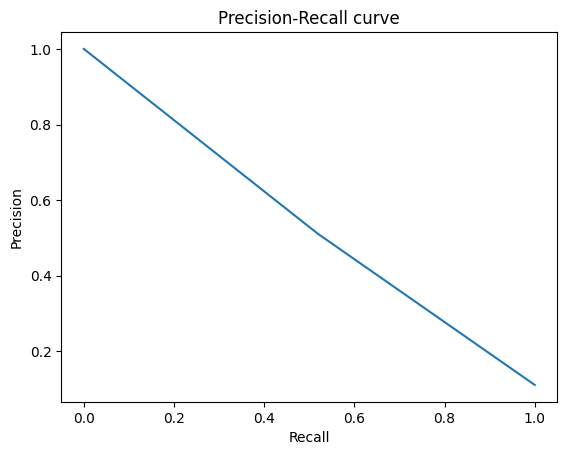

In [129]:
save_model_and_performance(model, X, Y, 'decision_tree')

It is quite apparent that decision tree is getting overfitted with the given dataset. In cross validation done below, all the metrics are performing worse than the logistic regression. Also the PR curve is almost like a random classifier

||>> Precision:  0.5061961206896551
||>> Recall:  0.5122682660850599
||>> F1:  0.5092140921409214
||>> Accuracy:  0.8900425015179113
||>> AUC:  0.7257276392027783


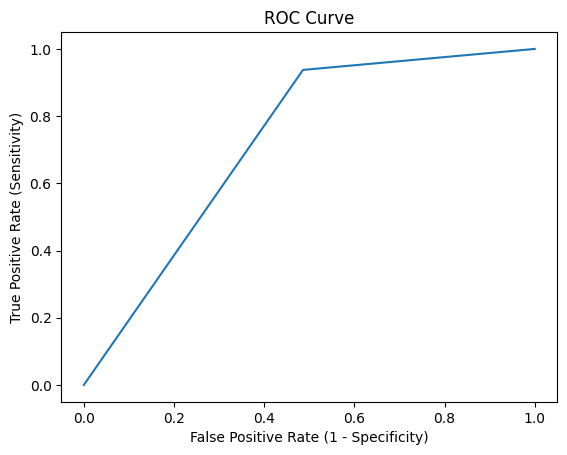

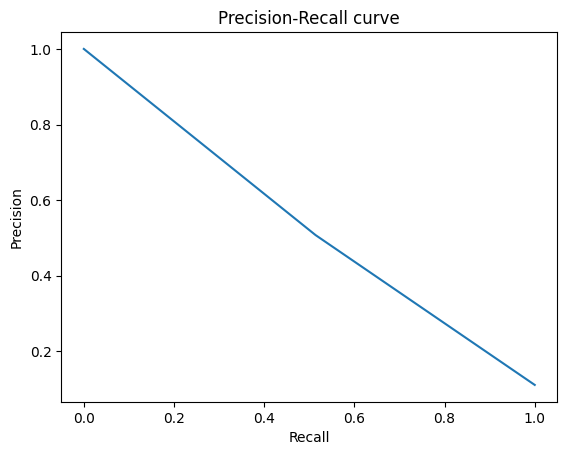

||>> AUPRC:  0.537854243843555


(0.5061961206896551,
 0.5122682660850599,
 0.5092140921409214,
 0.8900425015179113,
 0.7257276392027783,
 0.537854243843555)

In [109]:
from sklearn.model_selection import cross_val_predict

model = DecisionTreeClassifier()

Y_pred = cross_val_predict(model, X, Y, cv=10)
Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')

_ = evaluation_metrics(Y, Y_pred, Y_prob)

# Random Forest Classifier

In [130]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, Y_train)
train_score = model.score(X_train, Y_train)

valid_score = model.score(X_test, Y_test)

print("Train accuracy: ", train_score)
print("Test accuracy: ", valid_score)

Train accuracy:  1.0
Test accuracy:  0.9134790528233151


||>> Precision:  0.6562141491395793
||>> Recall:  0.4678298800436205
||>> F1:  0.5462358745822059
||>> Accuracy:  0.9134486945962356
||>> AUC:  0.940008831728461
||>> AUPRC:  0.6369912306777111


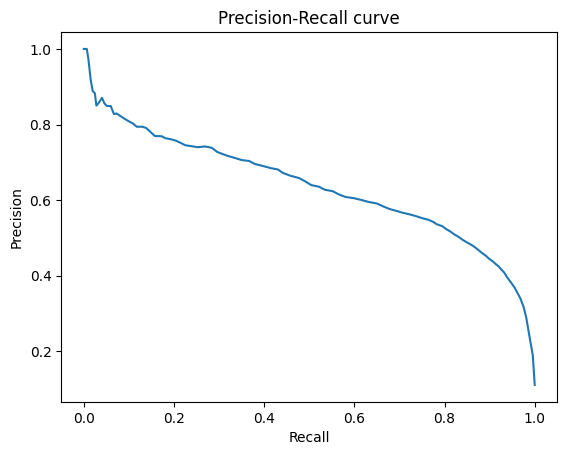

In [131]:
save_model_and_performance(model, X, Y, 'random_forest_classifier')

The Random Forest Classifier's performance is marginally better than Logistic regression model

||>> Precision:  0.6575133485888635
||>> Recall:  0.47001090512540894
||>> F1:  0.5481717011128776
||>> Accuracy:  0.9137219186399514
||>> AUC:  0.9392523612994117


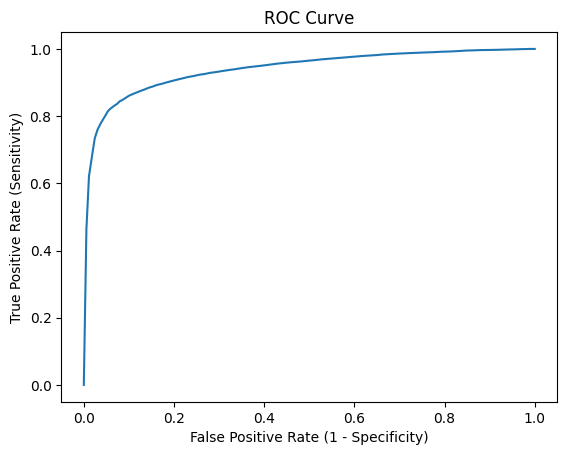

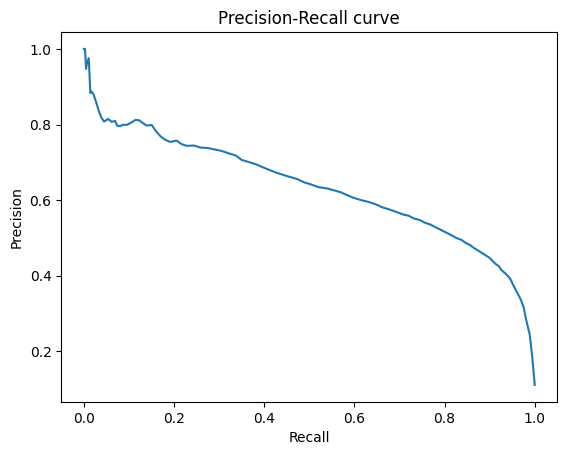

||>> AUPRC:  0.6338894298008876


In [125]:
from sklearn.model_selection import cross_val_predict

Y_pred = cross_val_predict(RandomForestClassifier(), X, Y, cv=5)
Y_prob = cross_val_predict(RandomForestClassifier(), X, Y, cv=5, method='predict_proba')

_ = evaluation_metrics(Y, Y_pred, Y_prob)

# XGBoost Classifier

In [137]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
val_score = model.score(X_test, Y_test)

print("Train accuracy: ", train_score)
print("Test accuracy: ", val_score)

Train accuracy:  0.9678582270795385
Test accuracy:  0.9096842744383729


||>> Precision:  0.6336025848142165
||>> Recall:  0.5346237731733915
||>> F1:  0.5799201537779092
||>> Accuracy:  0.913752276867031
||>> AUC:  0.9458396389610715
||>> AUPRC:  0.6360811192846303


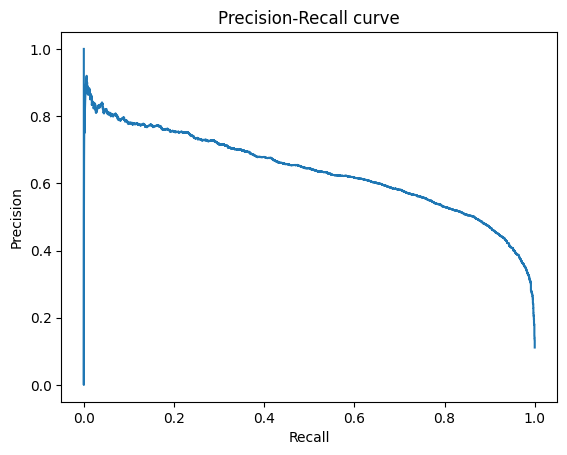

In [138]:
save_model_and_performance(model, X, Y, 'xgboost_classifier')

XGBoost classifier has performance comparable to random forest

||>> Precision:  0.6336025848142165
||>> Recall:  0.5346237731733915
||>> F1:  0.5799201537779092
||>> Accuracy:  0.913752276867031
||>> AUC:  0.9458396389610715


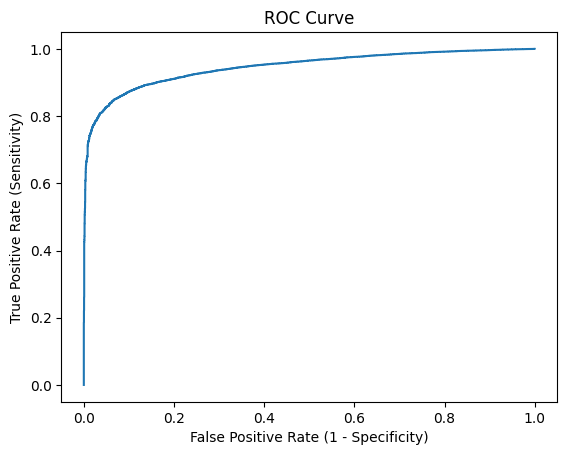

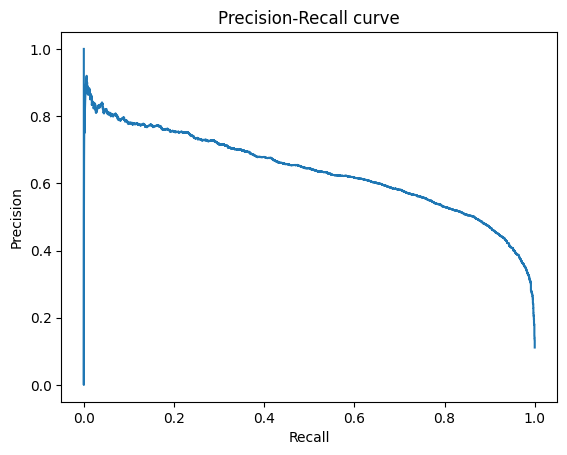

||>> AUPRC:  0.6360811192846303


In [136]:
from sklearn.model_selection import cross_val_predict

Y_pred = cross_val_predict(xgb.XGBClassifier(), X, Y, cv=10)
Y_prob = cross_val_predict(xgb.XGBClassifier(), X, Y, cv=10, method='predict_proba')

_ = evaluation_metrics(Y, Y_pred, Y_prob)